This notebook shows the plotting process for Figure 5.<br>
In the [draw subgraph(a)](#draw-subgraph(a)) section, we calculate scientists' average EP and ED in each year of their careers and plot the **Figure 5(a)** in the main text.<br>
In the [draw subgraph(b)](#draw-subgraph(b)) section, we compute the EP and ED of scientists' careers in different times and then draw **Figure 5(b)**.<br>
In the [draw subgraph(c)](#draw-subgraph(c)) section, we measure the movement of members in the four groups at 2000s and then graph **Figure 5(c)**.<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import scipy.stats
import plotly.graph_objects as go
import plotly

In [2]:
DATA_path = '../data/processing_data/'
distance_info = pd.read_pickle(DATA_path+"avg_switch_distance_info.pkl")
author_paper = pd.read_pickle(DATA_path+"author_paper.pkl")

# authors with more than 10 papers
author_paper = author_paper.loc[author_paper['paperCount'] >= 10]
all_author = set(author_paper['aid'].unique().tolist())
distance_info = distance_info.loc[distance_info['aid'].isin(all_author)]
distance_person = distance_info.groupby(['aid']).mean().reset_index()

In [3]:
author_paper['date'] = pd.to_datetime(author_paper['date'])
author_paper['year'] = author_paper['date'].dt.year
author_paper['firstyear'] = author_paper.aid.map(
    author_paper.groupby(['aid']).date.min().to_dict())
author_paper["CareerYear"] = (
    author_paper["date"]-author_paper["firstyear"]).dt.days//365 + 1

distance_info['lastDate'] = pd.to_datetime(distance_info['lastDate'])
distance_info['thisDate'] = pd.to_datetime(distance_info['thisDate'])
distance_info['year'] = distance_info['thisDate'].dt.year
distance_info['firstyear'] = distance_info.aid.map(
    distance_info.groupby(['aid']).lastDate.min().to_dict())
distance_info["CareerYear"] = (
    distance_info["thisDate"]-distance_info["firstyear"]).dt.days//365 + 1

# draw subgraph(a)
First, we calculate the EP and ED values for each year of the scientist's career, and then we can plot Figure 5(a).

## processing data

In [4]:
author_dis = distance_info[distance_info.groupby(['aid']).CareerYear.transform(
    'max') >= 15]  # screen scientists with at least 15 years of academic career
author_dis = author_dis[author_dis.CareerYear <= 30]
author_dis = author_dis[['aid', 'N5_es', 'N5_es_distance', 'CareerYear']]
author_dis.columns = ['aid', 'EP', 'ED', 'CareerYear']
author_dis.to_csv('../data/fig5/figure5a.csv', index=False)

## draw 

In [5]:
result = pd.read_csv('../data/fig5/figure5a.csv')

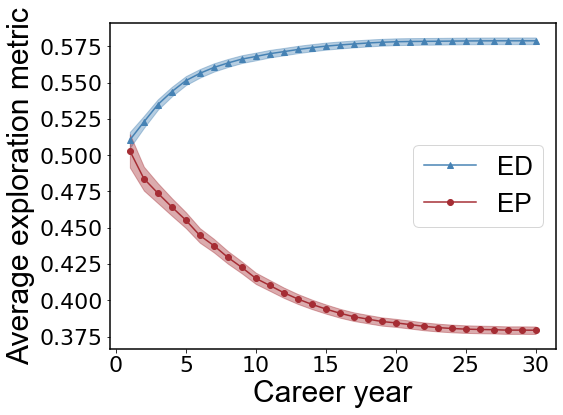

In [6]:
plt_x = []
plt_y = []
confi = []
plt_x_1 = []
plt_y_1 = []
confi_1 = []
count = []
CareerYear_list = list(result.CareerYear.unique())
CareerYear_list.sort()

for cyear in CareerYear_list:
    plt_x.append(cyear)
    group = result[result.CareerYear <= cyear].groupby(
        ['aid']).mean().reset_index()
    plt_y.append(group['EP'].mean())
    confi.append(scipy.stats.sem(group['EP']))
    plt_x_1.append(cyear)
    plt_y_1.append(group['ED'].mean())
    confi_1.append(scipy.stats.sem(group['ED']))
    count.append(group.shape[0])
plt_y = np.array(plt_y)
confi = np.array(confi)
plt_y_1 = np.array(plt_y_1)
confi_1 = np.array(confi_1)

# fig, ax = plt.subplots(figsize = (10, 8))
fig, ax = plt.subplots(figsize=(8, 6))
fontsize = 30
font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}

ax.plot(plt_x_1, plt_y_1, '^-', color='steelblue', label='ED')
ax.fill_between(plt_x_1, plt_y_1 - 1.96*confi_1, plt_y_1 +
                1.96*confi_1, color="steelblue", alpha=0.4)

color = (165/255, 45/255, 52/255)
ax.plot(plt_x, plt_y, 'o-', color=color, label='EP')
ax.fill_between(plt_x, plt_y - 1.96*confi, plt_y +
                1.96*confi, color=color, alpha=0.4)

ax.grid(False)


plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-8)
plt.ylabel('Average exploration metric', fontdict=font_conf)
plt.xlabel('Career year', fontdict=font_conf)
plt.legend(prop={'family': 'Arial', 'weight': 'normal', 'size': fontsize-4})

bwith = 1.5
ax = plt.gca()  # 获取边框
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)

plt.savefig('./draw/figure_5a.png', bbox_inches='tight')

# draw subgraph(b)
First, we calculate the EP and ED for authors who started their careers in (1985, 1990), (1990, 1995) and (1995, 2000), and then we can plot Figure 5(b).

## processing data

In [7]:
distance_info_draw = distance_info[distance_info.groupby(
    ['aid']).CareerYear.transform('max') >= 15]  # the same as 'draw subgraph(a)' section
# limit EP&ED to scientists’ first 15 years
distance_info_draw = distance_info_draw[distance_info_draw.CareerYear <= 15]
distance_info_draw = distance_info_draw[distance_info_draw.groupby(
    ['aid']).lastDate.transform('count') >= 9]
distance_info_draw = distance_info_draw[[
    'aid', 'N5_es', 'N5_es_distance', 'firstyear']]
distance_info_draw.columns = ['aid', 'EP', 'ED', 'startyear']
distance_info_draw.to_csv('../data/fig5/figure5b.csv', index=False)

## draw 

In [8]:
result = pd.read_csv('../data/fig5/figure5b.csv')
result.startyear = pd.to_datetime(result.startyear).dt.year

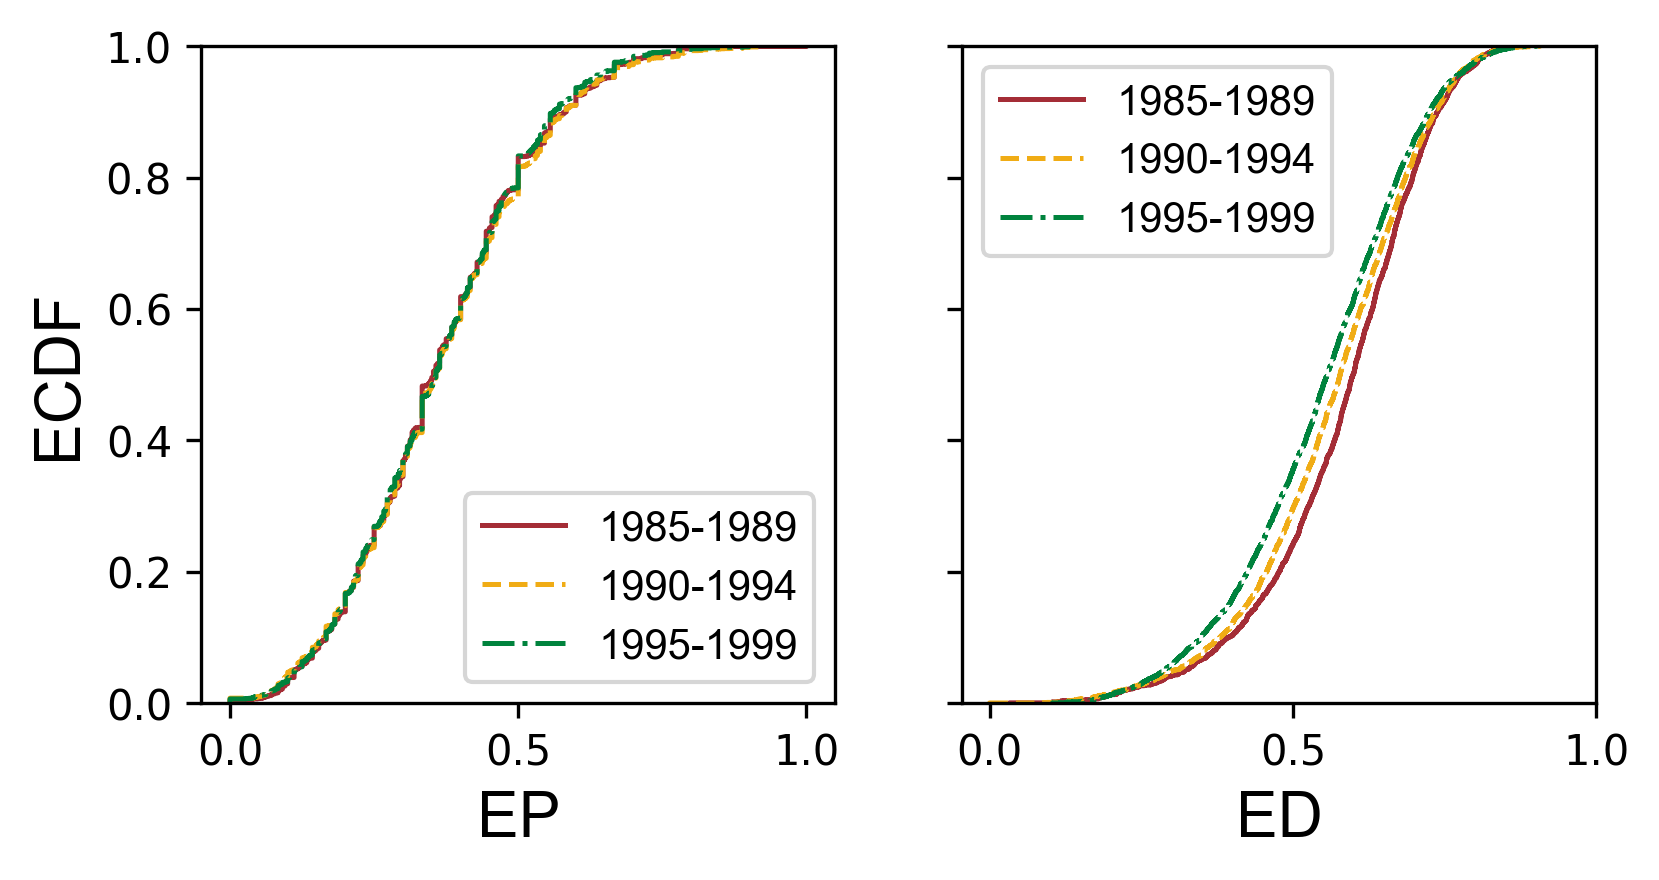

In [9]:
yearrange = [(1985, 1990), (1990, 1995), (1995, 2000)]
df = {}
for time in yearrange:
    df[time] = result.loc[result['startyear'] < time[1]].loc[result['startyear']
                                                             >= time[0]].groupby(['aid']).mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300, sharey=True)

colors = [(162/255, 41/255, 50/255, 0.98), (0.9411764705882353, 0.6745098039215687,
                                            0.08235294117647059, 1.0), (0.0, 0.5137254901960784, 0.23921568627450981, 1.0)]

markers = ['-', '--', '-.']
for time in yearrange:
    axesSub = sns.ecdfplot(df[time]["EP"], ax=ax[0], label=str(
        time[0])+'-'+str(time[1]-1), linewidth=1.2, color=colors[0], linestyle=markers[0])
    axesSub = sns.ecdfplot(df[time]["ED"], ax=ax[1], label=str(
        time[0])+'-'+str(time[1]-1), linewidth=1.2, color=colors[0], linestyle=markers[0])
    colors.pop(0)
    markers.pop(0)

fontsize = 15
font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}
ax[0].set_xticks([0, 0.5, 1], fontsize=fontsize-4, direction='out')
ax[0].grid(False)
ax[0].set_xlabel("EP", fontdict=font_conf)
ax[0].set_ylabel("ECDF", fontdict=font_conf)
ax[0].legend(prop={'family': 'Arial', 'weight': 'normal',
             'size': fontsize-5}, loc='best')

ax[1].set_xticks([0, 0.5, 1], fontsize=fontsize-4, direction='out')
ax[1].grid(False)
ax[1].set_xlabel("ED", fontdict=font_conf)
ax[1].legend(prop={'family': 'Arial', 'weight': 'normal',
             'size': fontsize-5}, loc='best')

plt.gcf().subplots_adjust(left=None, top=None, bottom=0.15, right=None)

plt.savefig('./draw/figure_5b.png',)

# draw subgraph(c)
First, we calculate the results of the grouping of scientists in 2000, 2003, 2006 and 2009, and then plot Figure 5(c).

## processing data

In [10]:
# select scientists who have at least two papers before 2000 and at least one paper after 2009,
cutyear = 2000
endyear = 2010
all_author = distance_info[(distance_info.groupby(['aid']).thisDate.transform('min') < pd.to_datetime(str(cutyear+1))) &
                           (distance_info.groupby(['aid']).thisDate.transform(
                               'max') >= pd.to_datetime(str(endyear)))
                           ].aid.unique()
distance_info = distance_info.loc[distance_info['aid'].isin(all_author)]

In [11]:
# Calculate data on performance, exploration metrics, etc. before and after split point
def career(careeryear):
    author_paper_after = author_paper[author_paper.date.dt.year > cutyear].groupby(
        ['aid']).agg({'logCit': 'mean', 'paperDoi': 'count'}).reset_index()
    author_paper_before = author_paper[author_paper.date.dt.year <= careeryear]
    author_paper_before = author_paper_before[author_paper_before.aid.isin(
        author_paper_after.aid)]
    author_paper_before1 = author_paper_before.groupby(['aid']).agg(
        {'logCit': 'mean', 'paperDoi': 'count', 'firstyear': 'min'}).reset_index()
    author_paper_before1.firstyear = author_paper_before1.firstyear.dt.year

    distance_info_before = distance_info_re[distance_info_re.thisDate.dt.year <= careeryear]
    distance_info_before = distance_info_before[distance_info_before.aid.isin(
        author_paper_after.aid)]
    distance_info_before = distance_info_before.groupby(['aid']).agg(
        {'N5_es': 'mean', 'N5_es_distance': 'mean'}).reset_index()

    regression = author_paper_before1.merge(distance_info_before, on=['aid'])
    regression = regression.merge(author_paper_after, on=['aid'])
    regression = regression.rename(columns={'paperDoi_x': 'paperDoi'})

    regression = regression.loc[:, (regression != 0).any(axis=0)]
    regression.rename(columns={'N5_es_distance': 'switch', 'logCit_x': 'pre_citCount', 'firstyear': 'firstyear', 'two_code_genres': 'genre_level0',
                               'first_genre': 'genre_level0', 'N5_es': 'es', 'paperDoi': 'Ncount', 'logCit_y': 'logCit', 'paperDoi_y': 'post_paperCount'}, inplace=True)
    regression['firstyear'] = regression['firstyear'].astype(
        'str').str.replace('', 'a', 1)

    return regression

In [12]:
gap = 3
indexlist = range(cutyear, cutyear+3*gap+1, gap)
total = pd.DataFrame({'aid': list(all_author)})
total.aid = total.aid.astype('str')

In [13]:
# get four groups in the 2000s
for careeryear in indexlist:
    distance_info_re = distance_info.rename(columns={'N5_es': 'N5_es'})
    paper = career(careeryear)
    paper = paper[paper.aid.isin(total.aid)]

    switchcut1 = list(paper['switch'].quantile(
        [.05, .1, .15, .2,  .25, .3, .4, .5, .6, .7, .75, .8, .85, .9, .95]))
    switchcut2 = list(paper['es'].quantile(
        [.05, .1, .15, .2,  .25, .3, .4, .5, .6, .7, .75, .8, .85, .9, .95]))

    print(switchcut2[6:9])

    count_i = 7
    for label in ['quantile_50']:
        if (count_i == 7):
            paper.loc[(paper.switch < switchcut1[count_i]) & (
                paper.es > switchcut2[count_i]), label] = 3
            paper.loc[(paper.switch < switchcut1[count_i]) & (
                paper.es < switchcut2[count_i]), label] = 2
            paper.loc[(paper.switch > switchcut1[count_i]) & (
                paper.es > switchcut2[count_i]), label] = 1
            paper.loc[(paper.switch > switchcut1[count_i]) & (
                paper.es < switchcut2[count_i]), label] = 0

        else:
            paper.loc[(paper.switch <= switchcut1[count_i]) & (
                paper.es >= switchcut2[count_i]), label] = 3
            paper.loc[(paper.switch <= switchcut1[count_i]) & (
                paper.es <= switchcut2[count_i]), label] = 2
            paper.loc[(paper.switch >= switchcut1[count_i]) & (
                paper.es >= switchcut2[count_i]), label] = 1
            paper.loc[(paper.switch >= switchcut1[count_i]) & (
                paper.es <= switchcut2[count_i]), label] = 0

        count_i += 1

    paper.loc[paper[label] == 3, ''+str(int(careeryear))+''] = 'A'
    paper.loc[paper[label] == 2, ''+str(int(careeryear))+''] = 'B'
    paper.loc[paper[label] == 1, ''+str(int(careeryear))+''] = 'C'
    paper.loc[paper[label] == 0, ''+str(int(careeryear))+''] = 'D'

    paper = paper[[''+str(int(careeryear))+'']+['aid']]
    total = paper.merge(total, on=['aid'], how='right')

[0.3333333333333333, 0.41379310344827586, 0.5]
[0.3333333333333333, 0.3888888888888889, 0.4444444444444444]
[0.3333333333333333, 0.375, 0.42857142857142855]
[0.3333333333333333, 0.375, 0.4166666666666667]


In [14]:
out = total[['aid', '2000', '2003', '2006', '2009']]
out.to_csv('../data/fig5/figure5c.csv', index=False)

## draw 

In [15]:
result = pd.read_csv('../data/fig5/figure5c.csv')
indexlist = range(2000, 2010, 3)

In [16]:
# set drawing parameters
def get_color(i):
    if (i.find('B') >= 0):
        return "rgba(35,127,54, 0.98)"
    if (i.find('C') >= 0):
        return "rgba(162,41,50, 0.98)"
    if (i.find('D') >= 0):
        return "rgba(24, 92, 143, 0.98)"
    return "rgba(238, 172, 25, 0.98)"


def get_y_index(label):
    if (label.find('A') >= 0):
        return 0.004
    if (label.find('B') >= 0):
        return 0.245
    if (label.find('C') >= 0):
        return 0.595
    if (label.find('D') >= 0):
        return 0.835


def get_x_index(label):
    for i in range(len(list(indexlist))):
        if (label == str(indexlist[i])):
            return i * (1/len(list(indexlist))) + 0.005

In [17]:
# format data into dict
nodes = {}
pre = str(indexlist[0])
for now in indexlist[1:]:
    now = ''+str(int(now))+''

    t = (result.groupby([pre])[now].value_counts(normalize=False))
    t = t.sort_index()
    for k in t.index:
        if (t[k] == 0):
            continue
        nodes[(f'Group {k[0]} in {int(pre)} year')] = {
            'color': get_color(k[0]), 'year': pre}
        nodes[(f'Group {k[1]} in {int(now)} year')] = {
            'color': get_color(k[1]), 'year': now}
    pre = now

nodes_keys = list(set(nodes.keys()))
nodes_keys.sort()
dict_ = dict(zip(nodes_keys, range(0, len(nodes_keys))))

links = {}
pre = str(indexlist[0])
for now in indexlist[1:]:
    now = ''+str(int(now))+''

    t = (result.groupby([pre])[now].value_counts(normalize=False))
    t = t.sort_index()
    for k in t.index:
        if (t[k] == 0):
            continue

        links[len(links)] = {'source': dict_[(f'Group {k[0]} in {int(pre)} year')],
                             'target': dict_[(f'Group {k[1]} in {int(now)} year')],
                             'value': t[k],
                             'color': get_color(k[0])}
    pre = now

links_dict = {'source': [], 'target': [], 'color': [], 'value': []}
for i in links:
    links_dict['source'].append(links[i]['source'])
    links_dict['target'].append(links[i]['target'])
    links_dict['color'].append(links[i]['color'].replace("0.98", str(.6)))
    links_dict['value'].append(links[i]['value'])

In [18]:
nodes_dict = {'label': [], 'color': [], 'x': [], 'y': [], 'thickness': 20}
count = 0
for i in nodes_keys:
    nodes_dict['color'].append(nodes[i]['color'])
    nodes_dict['x'].append(get_x_index(nodes[i]['year']))
    nodes_dict['y'].append(get_y_index(i))
    count += 1

In [19]:
data = go.Sankey(link=links_dict, node=nodes_dict)
fig = go.Figure(data)
fig.update_layout(title=" ",  font_size=12, width=1900, height=800)
plotly.offline.plot(fig, filename='./draw/figure_5c.html')

'./draw/figure_5c.html'